In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

import oracledb
oracledb.init_oracle_client()
from sklearn.model_selection import train_test_split

from scipy import stats

In [2]:
gold = pd.read_csv('data-files/gold.csv', encoding="utf-8")
kospi = pd.read_csv('data-files/kospi.csv', encoding="utf-8")
nasdaq = pd.read_csv('data-files/nasdaq.csv', encoding="utf-8")
oil_price = pd.read_csv('data-files/oil_price.csv', encoding="utf-8")
us_treasury = pd.read_csv('data-files/us_treasury.csv', encoding="utf-8")
usd_krw = pd.read_csv('data-files/usd_krw.csv', encoding="utf-8")
vix = pd.read_csv('data-files/vix.csv', encoding="utf-8")

In [3]:
kospi = kospi.rename(columns={'datetime':'날짜'})
kospi = kospi.rename(columns={'변동 %':'변동 %'})
kospi = kospi.sort_values(by='날짜', axis=0, ascending=False)
kospi['날짜'] = kospi['날짜'].str.replace('-', '- ')
kospi = kospi.reset_index(drop=True)

In [4]:
kospi

,날짜,종가,시가,고가,저가,거래량,변동 %
0,2023- 12- 28,362.70,355.50,362.70,355.20,256858,1.91%
1,2023- 12- 27,355.90,352.15,356.15,351.85,253005,1.11%
2,2023- 12- 26,352.00,352.45,352.80,350.05,173170,0.37%
3,2023- 12- 22,350.70,351.45,353.35,350.20,187933,0.52%
4,2023- 12- 21,348.90,349.00,350.50,347.60,202375,-0.78%
...,...,...,...,...,...,...,...
4691,2005- 01- 07,112.80,113.95,114.30,112.45,198190,-0.92%
4692,2005- 01- 06,113.85,114.40,115.60,113.55,215143,-0.91%
4693,2005- 01- 05,114.90,113.90,115.30,113.55,176376,-0.48%
4694,2005- 01- 04,115.45,115.30,116.40,115.00,169458,-0.17%


In [5]:
# kospi['날짜'][0] == gold['날짜'][1]

In [6]:
gold.info()
kospi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894 entries, 0 to 4893
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      4894 non-null   object
 1   종가      4894 non-null   object
 2   시가      4894 non-null   object
 3   고가      4894 non-null   object
 4   저가      4894 non-null   object
 5   거래량     4874 non-null   object
 6   변동 %    4894 non-null   object
dtypes: object(7)
memory usage: 267.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4696 entries, 0 to 4695
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      4696 non-null   object 
 1   종가      4696 non-null   float64
 2   시가      4696 non-null   float64
 3   고가      4696 non-null   float64
 4   저가      4696 non-null   float64
 5   거래량     4696 non-null   int64  
 6   변동 %    4695 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 256.9+ KB


In [7]:
gold, kospi, nasdaq, oil_price, us_treasury, usd_krw, vix

(                날짜        종가        시가        고가        저가      거래량    변동 %
 0     2023- 12- 29  2,071.80  2,076.10  2,084.10  2,067.60  105.72K  -0.56%
 1     2023- 12- 28  2,083.50  2,089.50  2,098.20  2,074.60  129.54K   0.00%
 2     2023- 12- 27  2,083.40  2,068.00  2,085.30  2,063.30    0.59K   1.12%
 3     2023- 12- 26  2,060.40  2,056.30  2,069.60  2,056.30    0.29K  -0.30%
 4     2023- 12- 25  2,066.65  2,065.30  2,067.60  2,065.30      NaN   0.34%
 ...            ...       ...       ...       ...       ...      ...     ...
 4889  2005- 01- 07    419.50    422.10    425.80    417.20   97.97K  -0.50%
 4890  2005- 01- 06    421.60    427.00    428.30    421.10   65.18K  -1.33%
 4891  2005- 01- 05    427.30    429.00    429.30    425.90   43.72K  -0.44%
 4892  2005- 01- 04    429.20    430.40    431.30    424.80   54.83K  -0.12%
 4893  2005- 01- 03    429.70    438.90    438.90    427.80   82.85K  -1.98%
 
 [4894 rows x 7 columns],
                 날짜      종가      시가      고가     

In [8]:
gold.shape, kospi.shape, nasdaq.shape, oil_price.shape, us_treasury.shape, usd_krw.shape, vix.shape

((4894, 7), (4696, 7), (4781, 7), (4908, 7), (4937, 7), (4955, 7), (4804, 7))

In [9]:
dataframes = [gold, kospi, nasdaq]
merged_df = reduce(lambda left, right: pd.merge(left, right, on='날짜',how='outer', suffixes=('_x', '_y')), dataframes)

In [10]:
dataframes2 = [oil_price, us_treasury, usd_krw]
merged_df2 = reduce(lambda left, right: pd.merge(left, right, on='날짜', how='outer', suffixes=('_x', '_y')), dataframes2)

In [11]:
dataframes3 = [merged_df, merged_df2, vix]
merged_df3 = reduce(lambda left, right: pd.merge(left, right, on='날짜', how='outer', suffixes=('_x', '_y')), dataframes3)

In [12]:
# gold, kospi, nasdaq, oil_price, us_treasury, usd_krw, vix
# pd.merge(gold, kospi, on='날짜', how="left")

# merged_quotes = gold
# for name, quotes in zip(["kospi", "nasdaq", "oil_price", "us_treasury", "usd_krw", "vix"], [kospi, nasdaq, oil_price, us_treasury, usd_krw, vix]):
#     merged_quotes = pd.merge(merged_quotes, quotes, on='날짜', how="left", suffixes=('', f'_{name}'))


In [13]:
# kospi['날짜'][0] == gold['날짜'][1]
# kospi['날짜'][0], gold['날짜'][1], vix['날짜'][1]

In [14]:
merged_df3

,날짜,종가_x_x,시가_x_x,고가_x_x,저가_x_x,거래량_x_x,변동 %_x_x,종가_y_x,시가_y_x,고가_y_x,...,고가_y,저가_y,거래량_y,변동 %_y,종가,시가,고가,저가,거래량,변동 %
0,2023- 12- 29,"2,071.80","2,076.10","2,084.10","2,067.60",105.72K,-0.56%,NaN,NaN,NaN,...,"1,301.36","1,284.02",NaN,0.41%,12.45,12.55,13.19,12.36,NaN,-0.16%
1,2023- 12- 28,"2,083.50","2,089.50","2,098.20","2,074.60",129.54K,0.00%,362.7,355.50,362.70,...,"1,295.00","1,285.34",NaN,-0.34%,12.47,12.44,12.65,12.38,NaN,0.32%
2,2023- 12- 27,"2,083.40","2,068.00","2,085.30","2,063.30",0.59K,1.12%,355.9,352.15,356.15,...,"1,297.28","1,292.30",NaN,0.01%,12.43,13.02,13.04,12.37,NaN,-4.31%
3,2023- 12- 26,"2,060.40","2,056.30","2,069.60","2,056.30",0.29K,-0.30%,352.0,352.45,352.80,...,"1,300.15","1,291.82",NaN,-0.11%,12.99,13.77,13.80,12.96,NaN,-0.31%
4,2023- 12- 25,"2,066.65","2,065.30","2,067.60","2,065.30",NaN,0.34%,NaN,NaN,NaN,...,"1,299.45","1,296.12",NaN,-0.14%,13.03,13.03,13.03,13.03,NaN,0.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,2008- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"1,306.80","1,306.80",NaN,0.00%,NaN,NaN,NaN,NaN,NaN,NaN
5031,2008- 01- 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,936.10,936.00,NaN,0.01%,NaN,NaN,NaN,NaN,NaN,NaN
5032,2007- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,939.70,939.60,NaN,0.00%,NaN,NaN,NaN,NaN,NaN,NaN
5033,2007- 01- 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,930.00,930.00,NaN,0.00%,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
merged_df3['거래량_y_x']

0            NaN
1       256858.0
2       253005.0
3       173170.0
4            NaN
          ...   
5030         NaN
5031         NaN
5032         NaN
5033         NaN
5034         NaN
Name: 거래량_y_x, Length: 5035, dtype: float64

In [16]:
# ['변동 %_x_x', '변동 %_y_x', '변동 %_x', '변동 %_x_y', '변동 %_y_y', '변동 %_y', '변동 %']

In [17]:
selected_columns = ['날짜', '종가_y_x', '시가_y_x', '고가_y_x', '저가_y_x', '거래량_y_x','변동 %_y_x','변동 %_x_x', '변동 %_x', '변동 %_x_y', '변동 %_y_y', '변동 %_y', '변동 %']
result_df = merged_df3[selected_columns]

In [18]:
kospi

,날짜,종가,시가,고가,저가,거래량,변동 %
0,2023- 12- 28,362.70,355.50,362.70,355.20,256858,1.91%
1,2023- 12- 27,355.90,352.15,356.15,351.85,253005,1.11%
2,2023- 12- 26,352.00,352.45,352.80,350.05,173170,0.37%
3,2023- 12- 22,350.70,351.45,353.35,350.20,187933,0.52%
4,2023- 12- 21,348.90,349.00,350.50,347.60,202375,-0.78%
...,...,...,...,...,...,...,...
4691,2005- 01- 07,112.80,113.95,114.30,112.45,198190,-0.92%
4692,2005- 01- 06,113.85,114.40,115.60,113.55,215143,-0.91%
4693,2005- 01- 05,114.90,113.90,115.30,113.55,176376,-0.48%
4694,2005- 01- 04,115.45,115.30,116.40,115.00,169458,-0.17%


In [19]:
result_df

,날짜,종가_y_x,시가_y_x,고가_y_x,저가_y_x,거래량_y_x,변동 %_y_x,변동 %_x_x,변동 %_x,변동 %_x_y,변동 %_y_y,변동 %_y,변동 %
0,2023- 12- 29,NaN,NaN,NaN,NaN,NaN,NaN,-0.56%,-0.43%,-0.17%,0.00%,0.41%,-0.16%
1,2023- 12- 28,362.7,355.50,362.70,355.20,256858.0,1.91%,0.00%,-0.05%,-3.16%,-0.39%,-0.34%,0.32%
2,2023- 12- 27,355.9,352.15,356.15,351.85,253005.0,1.11%,1.12%,0.17%,-1.93%,0.54%,0.01%,-4.31%
3,2023- 12- 26,352.0,352.45,352.80,350.05,173170.0,0.37%,-0.30%,0.60%,2.41%,0.08%,-0.11%,-0.31%
4,2023- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,0.34%,NaN,0.31%,-0.08%,-0.14%,0.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,2008- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00%,NaN
5031,2008- 01- 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01%,NaN
5032,2007- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00%,NaN
5033,2007- 01- 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00%,NaN


In [ ]:
result_df.rename(columns={'종가_y_x': '코스피_종가', '시가_y_x': '코스피_시가', '고가_y_x': '코스피_고가', 
                   '저가_y_x': '코스피_저가', '거래량_y_x': '코스피_거래량', '변동 %_y_x': '코스피_변동', '변동 %_x_x': '금_변동', '변동 %_x': '나스닥_변동', '변동 %_x_y': '유가_변동'
                   ,'변동 %_y_y': '미국채_변동', '변동 %_y': '환율_변동', '변동 %': 'vix_변동'}, inplace=True)

In [21]:
result_df

,날짜,코스피_종가,코스피_시가,코스피_고가,코스피_저가,코스피_거래량,코스피_변동,금_변동,나스닥_변동,유가_변동,미국채_변동,환율_변동,vix_변동
0,2023- 12- 29,NaN,NaN,NaN,NaN,NaN,NaN,-0.56%,-0.43%,-0.17%,0.00%,0.41%,-0.16%
1,2023- 12- 28,362.7,355.50,362.70,355.20,256858.0,1.91%,0.00%,-0.05%,-3.16%,-0.39%,-0.34%,0.32%
2,2023- 12- 27,355.9,352.15,356.15,351.85,253005.0,1.11%,1.12%,0.17%,-1.93%,0.54%,0.01%,-4.31%
3,2023- 12- 26,352.0,352.45,352.80,350.05,173170.0,0.37%,-0.30%,0.60%,2.41%,0.08%,-0.11%,-0.31%
4,2023- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,0.34%,NaN,0.31%,-0.08%,-0.14%,0.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030,2008- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00%,NaN
5031,2008- 01- 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01%,NaN
5032,2007- 12- 25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00%,NaN
5033,2007- 01- 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00%,NaN


In [22]:

result_df.isna().sum()
droped_result_df = result_df.dropna()

In [23]:
droped_result_df

,날짜,코스피_종가,코스피_시가,코스피_고가,코스피_저가,코스피_거래량,코스피_변동,금_변동,나스닥_변동,유가_변동,미국채_변동,환율_변동,vix_변동
1,2023- 12- 28,362.70,355.50,362.70,355.20,256858.0,1.91%,0.00%,-0.05%,-3.16%,-0.39%,-0.34%,0.32%
2,2023- 12- 27,355.90,352.15,356.15,351.85,253005.0,1.11%,1.12%,0.17%,-1.93%,0.54%,0.01%,-4.31%
3,2023- 12- 26,352.00,352.45,352.80,350.05,173170.0,0.37%,-0.30%,0.60%,2.41%,0.08%,-0.11%,-0.31%
5,2023- 12- 22,350.70,351.45,353.35,350.20,187933.0,0.52%,0.87%,0.12%,-0.45%,-0.07%,0.18%,-4.54%
6,2023- 12- 21,348.90,349.00,350.50,347.60,202375.0,-0.78%,0.18%,1.23%,-0.44%,-0.10%,-0.63%,-0.15%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4888,2005- 01- 10,113.70,113.20,113.75,112.40,145996.0,0.80%,0.05%,0.01%,-0.22%,0.01%,0.00%,-1.93%
4889,2005- 01- 07,112.80,113.95,114.30,112.45,198190.0,-0.92%,-0.50%,0.47%,-0.29%,-0.09%,-0.47%,-0.66%
4890,2005- 01- 06,113.85,114.40,115.60,113.55,215143.0,-0.91%,-1.33%,-0.40%,5.00%,0.06%,1.16%,-3.62%
4891,2005- 01- 05,114.90,113.90,115.30,113.55,176376.0,-0.48%,-0.44%,-0.51%,-1.18%,0.00%,0.76%,0.79%


In [ ]:
def remove_percentage(column):
    return column.str.replace('%', '').astype(float)

# 여러 개의 컬럼에 함수 적용
percentage_columns = ['코스피_변동', '금_변동', '나스닥_변동', '유가_변동', '미국채_변동', '환율_변동', 'vix_변동']
droped_result_df[percentage_columns] = droped_result_df[percentage_columns].apply(remove_percentage)

In [25]:
# droped_result_df['코스피_거래량'] = droped_result_df['코스피_거래량'].str.replace('M', '')
# droped_result_df['코스피_거래량'] = droped_result_df['코스피_거래량'].str.replace('K', '')

In [ ]:
droped_result_df['코스피_거래량'] = droped_result_df['코스피_거래량'].replace('M', '')
droped_result_df['코스피_거래량'] = droped_result_df['코스피_거래량'].replace('K', '')

In [ ]:
droped_result_df["종가 - 시가"] = droped_result_df["코스피_종가"] - droped_result_df["코스피_시가"]
droped_result_df["고가 - 저가"] = droped_result_df["코스피_고가"] - droped_result_df["코스피_저가"]

In [28]:
droped_result_df = droped_result_df.drop(['코스피_종가', '코스피_시가'], axis=1)
droped_result_df = droped_result_df.drop(['코스피_고가', '코스피_저가'], axis=1)

In [29]:
droped_result_df = droped_result_df.sort_values(by='날짜')

In [30]:
droped_result_df = droped_result_df.reset_index(drop=True)

In [31]:
droped_result_df

,날짜,코스피_거래량,코스피_변동,금_변동,나스닥_변동,유가_변동,미국채_변동,환율_변동,vix_변동,종가 - 시가,고가 - 저가
0,2005- 01- 04,169458.0,-0.17,-0.12,-1.98,4.25,-0.42,0.10,-0.71,0.15,1.40
1,2005- 01- 05,176376.0,-0.48,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.00,1.75
2,2005- 01- 06,215143.0,-0.91,-1.33,-0.40,5.00,0.06,1.16,-3.62,-0.55,2.05
3,2005- 01- 07,198190.0,-0.92,-0.50,0.47,-0.29,-0.09,-0.47,-0.66,-1.15,1.85
4,2005- 01- 10,145996.0,0.80,0.05,0.01,-0.22,0.01,0.00,-1.93,0.50,1.35
...,...,...,...,...,...,...,...,...,...,...,...
4540,2023- 12- 21,202375.0,-0.78,0.18,1.23,-0.44,-0.10,-0.63,-0.15,-0.10,2.90
4541,2023- 12- 22,187933.0,0.52,0.87,0.12,-0.45,-0.07,0.18,-4.54,-0.75,3.15
4542,2023- 12- 26,173170.0,0.37,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75
4543,2023- 12- 27,253005.0,1.11,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30


In [32]:
columns_to_round = ['종가 - 시가', '고가 - 저가']
droped_result_df[columns_to_round] = droped_result_df[columns_to_round].round(2)

In [33]:
droped_result_df

,날짜,코스피_거래량,코스피_변동,금_변동,나스닥_변동,유가_변동,미국채_변동,환율_변동,vix_변동,종가 - 시가,고가 - 저가
0,2005- 01- 04,169458.0,-0.17,-0.12,-1.98,4.25,-0.42,0.10,-0.71,0.15,1.40
1,2005- 01- 05,176376.0,-0.48,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.00,1.75
2,2005- 01- 06,215143.0,-0.91,-1.33,-0.40,5.00,0.06,1.16,-3.62,-0.55,2.05
3,2005- 01- 07,198190.0,-0.92,-0.50,0.47,-0.29,-0.09,-0.47,-0.66,-1.15,1.85
4,2005- 01- 10,145996.0,0.80,0.05,0.01,-0.22,0.01,0.00,-1.93,0.50,1.35
...,...,...,...,...,...,...,...,...,...,...,...
4540,2023- 12- 21,202375.0,-0.78,0.18,1.23,-0.44,-0.10,-0.63,-0.15,-0.10,2.90
4541,2023- 12- 22,187933.0,0.52,0.87,0.12,-0.45,-0.07,0.18,-4.54,-0.75,3.15
4542,2023- 12- 26,173170.0,0.37,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75
4543,2023- 12- 27,253005.0,1.11,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30


In [34]:
droped_result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545 entries, 0 to 4544
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   날짜       4545 non-null   object 
 1   코스피_거래량  4545 non-null   float64
 2   코스피_변동   4545 non-null   float64
 3   금_변동     4545 non-null   float64
 4   나스닥_변동   4545 non-null   float64
 5   유가_변동    4545 non-null   float64
 6   미국채_변동   4545 non-null   float64
 7   환율_변동    4545 non-null   float64
 8   vix_변동   4545 non-null   float64
 9   종가 - 시가  4545 non-null   float64
 10  고가 - 저가  4545 non-null   float64
dtypes: float64(10), object(1)
memory usage: 390.7+ KB


In [35]:
droped_result_df_list = droped_result_df.values.tolist()

In [36]:
droped_result_df_list

[['2005- 01- 04',
  169458.0,
  -0.17,
  -0.12,
  -1.98,
  4.25,
  -0.42,
  0.1,
  -0.71,
  0.15,
  1.4],
 ['2005- 01- 05',
  176376.0,
  -0.48,
  -0.44,
  -0.51,
  -1.18,
  0.0,
  0.76,
  0.79,
  1.0,
  1.75],
 ['2005- 01- 06',
  215143.0,
  -0.91,
  -1.33,
  -0.4,
  5.0,
  0.06,
  1.16,
  -3.62,
  -0.55,
  2.05],
 ['2005- 01- 07',
  198190.0,
  -0.92,
  -0.5,
  0.47,
  -0.29,
  -0.09,
  -0.47,
  -0.66,
  -1.15,
  1.85],
 ['2005- 01- 10',
  145996.0,
  0.8,
  0.05,
  0.01,
  -0.22,
  0.01,
  0.0,
  -1.93,
  0.5,
  1.35],
 ['2005- 01- 11',
  179433.0,
  1.36,
  0.64,
  -0.74,
  0.77,
  0.17,
  -0.76,
  -0.3,
  1.75,
  2.35],
 ['2005- 01- 12',
  196451.0,
  -0.82,
  0.99,
  0.8,
  1.51,
  0.05,
  -0.29,
  -4.78,
  -0.95,
  1.35],
 ['2005- 01- 13',
  205386.0,
  0.83,
  -0.35,
  -1.32,
  3.6,
  0.32,
  -0.58,
  2.23,
  0.9,
  1.55],
 ['2005- 01- 14',
  219557.0,
  2.65,
  -0.42,
  1.03,
  0.71,
  -0.15,
  0.68,
  -3.19,
  3.95,
  4.25],
 ['2005- 01- 18',
  147412.0,
  -0.42,
  0.05,
  0.

In [37]:
# 데이터 베이스에 연결
conn2 = oracledb.connect(user="lab2", password="lab2", dsn="127.0.0.1:1521/xe")

# 명령 (SQL) 실행
cursor = conn2.cursor()

cursor.executemany("insert into stock values(:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11)", droped_result_df_list)      
cursor.execute("commit")

# 연결 종료
conn2.close()

In [96]:
# 데이터 베이스에 연결
conn2 = oracledb.connect(user="lab2", password="lab2", dsn="127.0.0.1:1521/xe")

# 명령 (SQL) 실행
cursor = conn2.cursor()
# SQL 쿼리 작성
sql_query = "SELECT * FROM stock"
stock = pd.read_sql_query(sql_query, conn2)

# 연결 종료
conn2.close()

C:\Users\Administrator.User -2023DBZJO\AppData\Local\Temp\ipykernel_13260\318945553.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stock = pd.read_sql_query(sql_query, conn2)


In [39]:
# print((stock3['KOSPI'] > 0.5).sum())
# print(stock3['KOSPI'].describe())
# plt.hist(stock3['KOSPI'], bins=100)
# plt.show()

In [97]:
stock2 = stock.copy()

In [99]:
# 데이터프레임을 CSV 파일로 저장
stock2.to_csv('stock2.csv', index=False)  # index=False를 지정하여 인덱스를 저장하지 않습니다.

In [ ]:
stock2 = pd.read_csv('stock2.csv')

In [98]:
stock2

,DAYS,KOSPI_VOLUME,KOSPI,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE
0,2005-01-03,101240000,0.10,-1.98,-1.09,-3.06,-0.05,0.22,5.94,-0.29,0.91
1,2005-01-04,119970000,-0.51,-0.12,-1.98,4.25,-0.42,0.10,-0.71,-0.23,1.30
2,2005-01-05,142310000,-0.10,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.24,1.48
3,2005-01-06,147880000,-1.49,-1.33,-0.40,5.00,0.06,1.16,-3.62,-0.94,2.03
4,2005-01-07,117390000,-0.20,-0.50,0.47,-0.29,-0.09,-0.47,-0.66,-0.90,1.76
...,...,...,...,...,...,...,...,...,...,...,...
9087,2023-12-21,202375,-0.78,0.18,1.23,-0.44,-0.10,-0.63,-0.15,-0.10,2.90
9088,2023-12-22,187933,0.52,0.87,0.12,-0.45,-0.07,0.18,-4.54,-0.75,3.15
9089,2023-12-26,173170,0.37,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75
9090,2023-12-27,253005,1.11,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30


In [42]:

stock['KOSPI'] = stock['KOSPI'].shift(-1)
stock['KOSPI_VOLUME'] = stock['KOSPI_VOLUME'].map(lambda v: float(v))

In [43]:
stock['KOSPI']

0      -0.51
1      -0.10
2      -1.49
3      -0.20
4       0.50
        ... 
9087    0.52
9088    0.37
9089    1.11
9090    1.91
9091     NaN
Name: KOSPI, Length: 9092, dtype: float64

In [44]:
# stock['KOSPI'] = stock['KOSPI'].map(lambda v: 1 if v > 2 else 0)

In [45]:
# stock['KOSPI'] = stock['KOSPI'].map(lambda v: 1 if v > 1 else -1 if v < -1 else 0) # 1라는 범위를 정하고 올랐는지 확인

In [46]:
stock['KOSPI'] = stock['KOSPI'].map(lambda v: 1 if v > 0 else 0)

In [47]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DAYS                  9092 non-null   datetime64[ns]
 1   KOSPI_VOLUME          9092 non-null   float64       
 2   KOSPI                 9092 non-null   int64         
 3   GOLD                  9092 non-null   float64       
 4   NASDAP                9092 non-null   float64       
 5   OIL                   9092 non-null   float64       
 6   US                    9092 non-null   float64       
 7   USD                   9092 non-null   float64       
 8   VIX                   9092 non-null   float64       
 9   DAILY_PRICE_RANGE     9092 non-null   float64       
 10  DAILY_HIGH_LOW_RANGE  9092 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 781.5 KB


In [48]:
stock = stock.dropna()

In [49]:
drop_stock = stock.drop(['KOSPI'], axis=1)

In [50]:
stock[stock['KOSPI'] > 1].shape
(stock['KOSPI'] > 1).sum()


0

In [51]:
drop_stock

,DAYS,KOSPI_VOLUME,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE
0,2005-01-03,101240000.0,-1.98,-1.09,-3.06,-0.05,0.22,5.94,-0.29,0.91
1,2005-01-04,119970000.0,-0.12,-1.98,4.25,-0.42,0.10,-0.71,-0.23,1.30
2,2005-01-05,142310000.0,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.24,1.48
3,2005-01-06,147880000.0,-1.33,-0.40,5.00,0.06,1.16,-3.62,-0.94,2.03
4,2005-01-07,117390000.0,-0.50,0.47,-0.29,-0.09,-0.47,-0.66,-0.90,1.76
...,...,...,...,...,...,...,...,...,...,...
9087,2023-12-21,202375.0,0.18,1.23,-0.44,-0.10,-0.63,-0.15,-0.10,2.90
9088,2023-12-22,187933.0,0.87,0.12,-0.45,-0.07,0.18,-4.54,-0.75,3.15
9089,2023-12-26,173170.0,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75
9090,2023-12-27,253005.0,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30


In [52]:
# drop_stock.abs()

In [53]:
stock['KOSPI']

0       0
1       0
2       0
3       0
4       1
       ..
9087    1
9088    1
9089    1
9090    1
9091    0
Name: KOSPI, Length: 9092, dtype: int64

In [54]:
drop_stock['GOLD'].describe()

count    9092.000000
mean        0.040572
std         1.112849
min        -9.340000
25%        -0.470000
50%         0.040000
75%         0.600000
max         8.970000
Name: GOLD, dtype: float64

In [55]:
stock['KOSPI']

0       0
1       0
2       0
3       0
4       1
       ..
9087    1
9088    1
9089    1
9090    1
9091    0
Name: KOSPI, Length: 9092, dtype: int64

In [56]:
drop_stock.columns

Index(['DAYS', 'KOSPI_VOLUME', 'GOLD', 'NASDAP', 'OIL', 'US', 'USD', 'VIX',
       'DAILY_PRICE_RANGE', 'DAILY_HIGH_LOW_RANGE'],
      dtype='object')

In [57]:
drop_stock_ca = drop_stock.copy()
drop_stock_ca['KOSPI_VOLUME'] = pd.qcut(drop_stock_ca['KOSPI_VOLUME'], q=[0, 1/6, 2/6, 3/6, 4/6, 5/6, 1], labels=['1', '2', '3', '4', '5', '6'])
xy_cross = pd.crosstab(stock['KOSPI'], drop_stock_ca['KOSPI_VOLUME'])
print('KOSPI_VOLUME', stats.chi2_contingency(xy_cross, correction=True))

KOSPI_VOLUME Chi2ContingencyResult(statistic=5.044701796219752, pvalue=0.4104491340205666, dof=5, expected_freq=array([[714.4808623 , 714.00956885, 714.00956885, 714.00956885,
        714.00956885, 714.4808623 ],
       [801.5191377 , 800.99043115, 800.99043115, 800.99043115,
        800.99043115, 801.5191377 ]]))


In [58]:
# 범주형 데이터 두 표본(두 속성)간 독립성 검정

stock_list = []
drop_stock_ca = drop_stock.copy()

for column in drop_stock_ca.columns:
    if column != 'DAYS':
        
        drop_stock_ca[column] = pd.qcut(drop_stock_ca[column], q=[0, 1/6, 2/6, 3/6, 4/6, 5/6, 1], labels=['1', '2', '3', '4', '5', '6'])

        xy_cross = pd.crosstab(stock['KOSPI'], drop_stock_ca[column])
        print(column, stats.chi2_contingency(xy_cross, correction=True))



KOSPI_VOLUME Chi2ContingencyResult(statistic=5.044701796219752, pvalue=0.4104491340205666, dof=5, expected_freq=array([[714.4808623 , 714.00956885, 714.00956885, 714.00956885,
        714.00956885, 714.4808623 ],
       [801.5191377 , 800.99043115, 800.99043115, 800.99043115,
        800.99043115, 801.5191377 ]]))
GOLD Chi2ContingencyResult(statistic=6.060655643504756, pvalue=0.300361532791324, dof=5, expected_freq=array([[714.95215574, 724.84931808, 719.66509019, 707.88275407,
        705.0549934 , 712.59568852],
       [802.04784426, 813.15068192, 807.33490981, 794.11724593,
        790.9450066 , 799.40431148]]))
NASDAP Chi2ContingencyResult(statistic=610.0578644220425, pvalue=1.3571479270877021e-129, dof=5, expected_freq=array([[714.95215574, 717.30862297, 734.27518698, 699.39947206,
        704.58369996, 714.4808623 ],
       [802.04784426, 804.69137703, 823.72481302, 784.60052794,
        790.41630004, 801.5191377 ]]))
OIL Chi2ContingencyResult(statistic=100.43291112502331, pvalue

In [59]:

# drop_stock['GOLD_Category'] = pd.qcut(drop_stock['GOLD'], q=[0, 1/6, 2/6, 3/6, 4/6, 5/6, 1], labels=['1', '2', '3', '4', '5', '6'])

In [60]:
# from scipy import stats
# stats.ttest_ind(drop_stock[stock['KOSPI'] == 0]['GOLD'], drop_stock[stock['KOSPI'] == 1]['GOLD'])

In [61]:
from scipy import stats

for column in drop_stock.columns:
    if column != 'DAYS':
        print(column,stats.ttest_ind(drop_stock[stock['KOSPI'] == 0][column], drop_stock[stock['KOSPI'] == 1][column]))



KOSPI_VOLUME TtestResult(statistic=-1.1664351050655277, pvalue=0.24346917314547273, df=9090.0)
GOLD TtestResult(statistic=-1.6205504646199362, pvalue=0.10514876915280034, df=9090.0)
NASDAP TtestResult(statistic=-24.50708572267053, pvalue=1.719630787316703e-128, df=9090.0)
OIL TtestResult(statistic=-4.827231703162182, pvalue=1.4070057093633283e-06, df=9090.0)
US TtestResult(statistic=4.651271054134518, pvalue=3.3455333610440637e-06, df=9090.0)
USD TtestResult(statistic=7.65684396094891, pvalue=2.100348015639228e-14, df=9090.0)
VIX TtestResult(statistic=23.427133256640932, pvalue=6.704186466118813e-118, df=9090.0)
DAILY_PRICE_RANGE TtestResult(statistic=3.759878545706638, pvalue=0.0001710617248537455, df=9090.0)
DAILY_HIGH_LOW_RANGE TtestResult(statistic=-2.1457541788999905, pvalue=0.03191899916825428, df=9090.0)


In [62]:
x = drop_stock
y = stock['KOSPI']

x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=99)

In [63]:
drop_stock

,DAYS,KOSPI_VOLUME,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE
0,2005-01-03,101240000.0,-1.98,-1.09,-3.06,-0.05,0.22,5.94,-0.29,0.91
1,2005-01-04,119970000.0,-0.12,-1.98,4.25,-0.42,0.10,-0.71,-0.23,1.30
2,2005-01-05,142310000.0,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.24,1.48
3,2005-01-06,147880000.0,-1.33,-0.40,5.00,0.06,1.16,-3.62,-0.94,2.03
4,2005-01-07,117390000.0,-0.50,0.47,-0.29,-0.09,-0.47,-0.66,-0.90,1.76
...,...,...,...,...,...,...,...,...,...,...
9087,2023-12-21,202375.0,0.18,1.23,-0.44,-0.10,-0.63,-0.15,-0.10,2.90
9088,2023-12-22,187933.0,0.87,0.12,-0.45,-0.07,0.18,-4.54,-0.75,3.15
9089,2023-12-26,173170.0,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75
9090,2023-12-27,253005.0,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30


In [64]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=99)

x_train_droped = x_train.drop(['DAYS'], axis=1)
x_test_droped = x_test.drop(['DAYS'], axis=1)

rfc.fit(x_train_droped, y_train)

rfc.score(x_train_droped, y_train), rfc.score(x_test_droped, y_test)

(1.0, 0.7976242850857898)

In [65]:
importances = rfc.feature_importances_

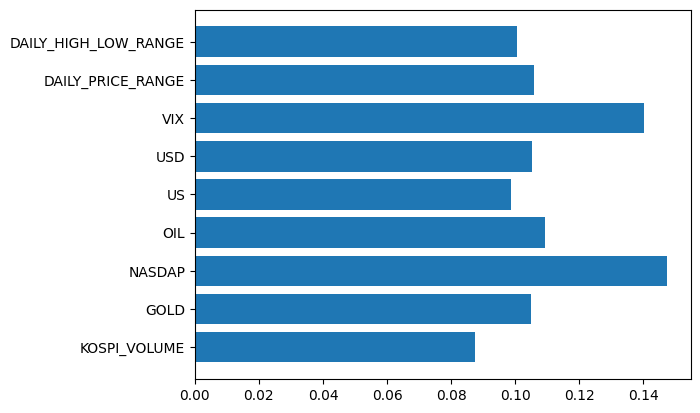

In [66]:
plt.barh(x_train_droped.columns, importances)
plt.show()

In [67]:
predict2 = rfc.predict(x_test_droped)
predict = rfc.predict(x_train_droped)

In [68]:
predict_df2 = pd.DataFrame(predict2)
predict_df = pd.DataFrame(predict)

predict_concat = pd.concat([predict_df, predict_df2], axis=0)

In [69]:
predict_concat = predict_concat.reset_index(drop=True)

In [70]:
predict_concat

,0
0,0
1,0
2,0
3,0
4,0
...,...
9087,0
9088,0
9089,1
9090,0


In [71]:
x_concat = pd.concat([x_train, x_test], axis=0)

In [72]:
x_concat = x_concat.reset_index(drop=True)

In [73]:
x_concat

,DAYS,KOSPI_VOLUME,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE
0,2020-02-20,385805.0,0.54,-0.94,0.92,0.27,1.02,8.21,-3.20,6.25
1,2015-10-21,122684.0,-0.88,-0.56,-0.77,0.25,0.76,6.03,0.70,3.00
2,2017-01-26,70100.0,-0.67,0.11,1.95,0.13,0.83,-1.67,1.33,2.74
3,2005-05-11,190104.0,0.00,0.63,-3.11,0.11,-0.18,-3.09,-0.95,1.65
4,2008-09-10,136160000.0,-3.72,0.96,-0.66,-0.32,-0.32,-3.73,4.49,5.11
...,...,...,...,...,...,...,...,...,...,...
9087,2014-04-03,69460.0,-0.48,-0.77,0.67,0.04,0.03,2.14,-0.65,2.42
9088,2019-02-01,243031.0,-0.23,-0.45,2.73,-0.43,0.63,-2.60,-1.50,3.15
9089,2019-04-08,64570000.0,0.49,0.28,2.09,-0.11,0.47,2.81,-1.40,2.74
9090,2018-08-13,226806.0,-1.65,-0.10,-0.64,-0.11,0.60,12.31,-1.60,3.80


In [74]:
predict_concat

,0
0,0
1,0
2,0
3,0
4,0
...,...
9087,0
9088,0
9089,1
9090,0


In [75]:
predict_concat = predict_concat.add_prefix('predicted_')
x_concat = pd.concat([x_concat, predict_concat], axis=1)

In [76]:
# predict_df2 = predict_df2.add_prefix('predicted_')
# x_concat = pd.concat([x_concat, predict_df2], axis=1)

In [77]:
x_concat = x_concat.sort_values(by='DAYS')

In [78]:
x_concat = x_concat.reset_index(drop=True)

In [79]:
# Create a list of DataFrames
# dfs_to_concat = [x_train_droped, x_test_droped]

# Concatenate the DataFrames along the columns (axis=1)
# a = pd.concat(dfs_to_concat, axis=1)

# a

In [80]:
# predict = rfc.predict(x_train_droped)
# x_train_droped['predict'] = predict
# x_train_droped

In [81]:
x_concat

,DAYS,KOSPI_VOLUME,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE,predicted_0
0,2005-01-03,101240000.0,-1.98,-1.09,-3.06,-0.05,0.22,5.94,-0.29,0.91,0
1,2005-01-04,169458.0,-0.12,-1.98,4.25,-0.42,0.10,-0.71,0.15,1.40,0
2,2005-01-04,119970000.0,-0.12,-1.98,4.25,-0.42,0.10,-0.71,-0.23,1.30,0
3,2005-01-05,176376.0,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.00,1.75,0
4,2005-01-05,142310000.0,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.24,1.48,0
...,...,...,...,...,...,...,...,...,...,...,...
9087,2023-12-26,173170.0,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75,1
9088,2023-12-27,253005.0,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30,1
9089,2023-12-27,129880000.0,1.12,0.17,-1.93,0.54,0.01,-4.31,2.41,3.53,1
9090,2023-12-28,256858.0,0.00,-0.05,-3.16,-0.39,-0.34,0.32,7.20,7.50,0


In [82]:
stock2

,DAYS,KOSPI_VOLUME,KOSPI,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE
0,2005-01-03,101240000,0.10,-1.98,-1.09,-3.06,-0.05,0.22,5.94,-0.29,0.91
1,2005-01-04,119970000,-0.51,-0.12,-1.98,4.25,-0.42,0.10,-0.71,-0.23,1.30
2,2005-01-05,142310000,-0.10,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.24,1.48
3,2005-01-06,147880000,-1.49,-1.33,-0.40,5.00,0.06,1.16,-3.62,-0.94,2.03
4,2005-01-07,117390000,-0.20,-0.50,0.47,-0.29,-0.09,-0.47,-0.66,-0.90,1.76
...,...,...,...,...,...,...,...,...,...,...,...
9087,2023-12-21,202375,-0.78,0.18,1.23,-0.44,-0.10,-0.63,-0.15,-0.10,2.90
9088,2023-12-22,187933,0.52,0.87,0.12,-0.45,-0.07,0.18,-4.54,-0.75,3.15
9089,2023-12-26,173170,0.37,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75
9090,2023-12-27,253005,1.11,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30


In [83]:
stock2['KOSPI'] = stock2['KOSPI'].shift(-1)

In [84]:
stock2['KOSPI'] = stock2['KOSPI'].map(lambda v: 1 if v > 0 else 0)

In [85]:
x_concat['reality'] = stock2['KOSPI']

In [86]:
x_concat

,DAYS,KOSPI_VOLUME,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE,predicted_0,reality
0,2005-01-03,101240000.0,-1.98,-1.09,-3.06,-0.05,0.22,5.94,-0.29,0.91,0,0
1,2005-01-04,169458.0,-0.12,-1.98,4.25,-0.42,0.10,-0.71,0.15,1.40,0,0
2,2005-01-04,119970000.0,-0.12,-1.98,4.25,-0.42,0.10,-0.71,-0.23,1.30,0,0
3,2005-01-05,176376.0,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.00,1.75,0,0
4,2005-01-05,142310000.0,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.24,1.48,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9087,2023-12-26,173170.0,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75,1,1
9088,2023-12-27,253005.0,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30,1,1
9089,2023-12-27,129880000.0,1.12,0.17,-1.93,0.54,0.01,-4.31,2.41,3.53,1,1
9090,2023-12-28,256858.0,0.00,-0.05,-3.16,-0.39,-0.34,0.32,7.20,7.50,0,1


In [87]:
# (x_concat['predicted_0'] == x_concat['reality']).sum()

In [88]:
(x_concat['predicted_0'] == x_concat['reality']).sum() / len(x_concat)

0.4947206335239771

In [89]:
(x_concat['predicted_0'] == x_concat['reality']).sum()

4498

In [90]:
# result_df = pd.concat([gold['변동 %'], kospi['변동 %']], axis=1)
# result_df = pd.merge(gold, kospi, on='날짜', how='outer')

In [91]:
# result_df[result_df["종가_y"].isna()].shape

In [92]:
# import os

# path = r'D:\\ohsangmin\\workspace\\ml\\data-files\\'
# file_list = os.listdir(path)
# print(file_list)
# print()

# dfs_lst = []
# for file_name in file_list:
#      df = pd.read_csv(path+file_name)
#      dfs_lst.append(df.copy())

In [93]:
x

,DAYS,KOSPI_VOLUME,GOLD,NASDAP,OIL,US,USD,VIX,DAILY_PRICE_RANGE,DAILY_HIGH_LOW_RANGE
0,2005-01-03,101240000.0,-1.98,-1.09,-3.06,-0.05,0.22,5.94,-0.29,0.91
1,2005-01-04,119970000.0,-0.12,-1.98,4.25,-0.42,0.10,-0.71,-0.23,1.30
2,2005-01-05,142310000.0,-0.44,-0.51,-1.18,0.00,0.76,0.79,1.24,1.48
3,2005-01-06,147880000.0,-1.33,-0.40,5.00,0.06,1.16,-3.62,-0.94,2.03
4,2005-01-07,117390000.0,-0.50,0.47,-0.29,-0.09,-0.47,-0.66,-0.90,1.76
...,...,...,...,...,...,...,...,...,...,...
9087,2023-12-21,202375.0,0.18,1.23,-0.44,-0.10,-0.63,-0.15,-0.10,2.90
9088,2023-12-22,187933.0,0.87,0.12,-0.45,-0.07,0.18,-4.54,-0.75,3.15
9089,2023-12-26,173170.0,-0.30,0.60,2.41,0.08,-0.11,-0.31,-0.45,2.75
9090,2023-12-27,253005.0,1.12,0.17,-1.93,0.54,0.01,-4.31,3.75,4.30


In [94]:
x.iloc[-2, :].values[1:]

array([253005.0, 1.12, 0.17, -1.93, 0.54, 0.01, -4.31, 3.75, 4.3],
      dtype=object)

In [95]:
rfc.predict([[14864.0, 1.12, 0.17, -1.93, 0.54, 0.01, -4.31, 3.75, 4.3]])

c:\ProgramData\miniconda3\envs\study-env\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)